In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


In [4]:
df = pd.read_parquet("data/air-quality-idx.parquet.gzip")
df.head()

/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
/Users/aapo/anaconda3/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Timestamp,Mannerheimintie,Air pressure (msl) (hPa),Relative humidity (%),Rain intensity (mm/h),Air temperature (degC),Wind direction (deg),Wind speed (m/s)
0,2014-01-01 01:00:00,78.0,1016.8,89.0,0.0,5.1,253.0,4.9
1,2014-01-01 02:00:00,68.0,1016.8,87.0,0.0,5.1,255.0,5.6
2,2014-01-01 03:00:00,60.0,1016.9,85.0,0.0,5.2,246.0,5.3
3,2014-01-01 04:00:00,48.0,1016.9,86.0,0.0,5.2,254.0,5.7
4,2014-01-01 05:00:00,51.0,1017.1,89.0,0.0,5.1,249.0,4.3


In [6]:
df.dtypes

Timestamp                   datetime64[ns]
Mannerheimintie                    float64
Air pressure (msl) (hPa)           float64
Relative humidity (%)              float64
Rain intensity (mm/h)              float64
Air temperature (degC)             float64
Wind direction (deg)               float64
Wind speed (m/s)                   float64
dtype: object

## Baseline model: ARIMA

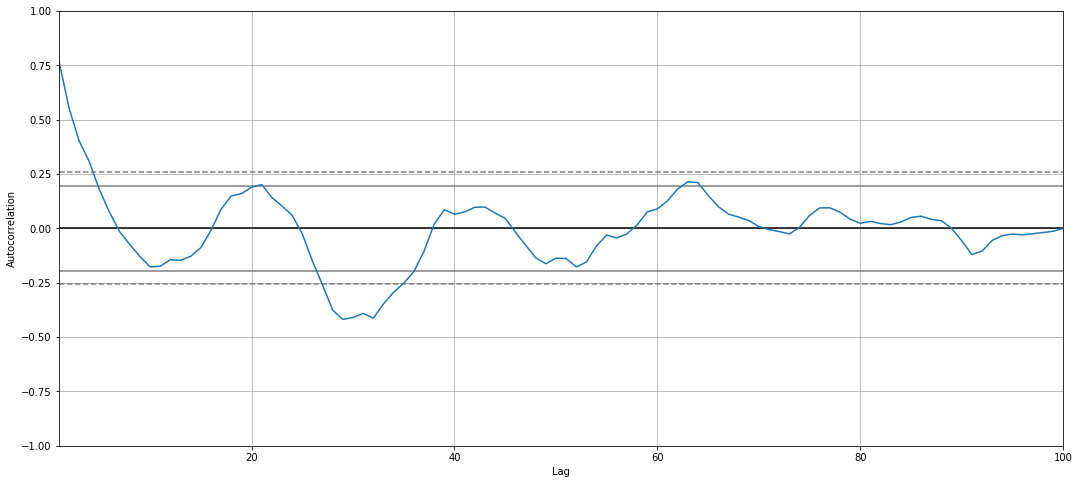

In [18]:
plt.figure(figsize=(18,8))
autocorrelation_plot(df["Mannerheimintie"].iloc[:100])


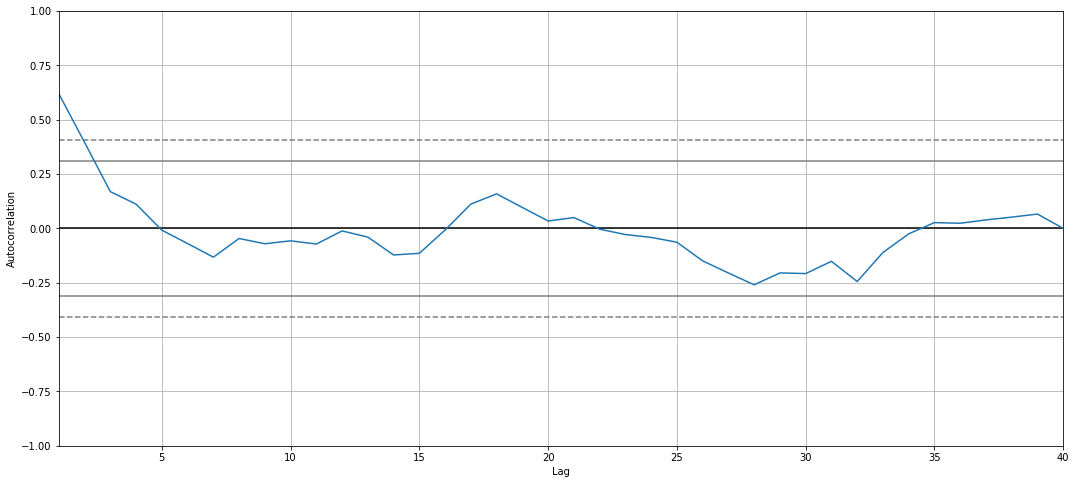

In [19]:
plt.figure(figsize=(18,8))
autocorrelation_plot(df["Mannerheimintie"].iloc[:40])

                             ARIMA Model Results                              
Dep. Variable:      D.Mannerheimintie   No. Observations:                47351
Model:                 ARIMA(5, 1, 0)   Log Likelihood             -176622.169
Method:                       css-mle   S.D. of innovations             10.086
Date:                Sun, 28 Jul 2019   AIC                         353258.338
Time:                        12:10:57   BIC                         353319.695
Sample:                             1   HQIC                        353277.607
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0011      0.029     -0.038      0.969      -0.057       0.055
ar.L1.D.Mannerheimintie    -0.2116      0.005    -46.105      0.000      -0.221      -0.203


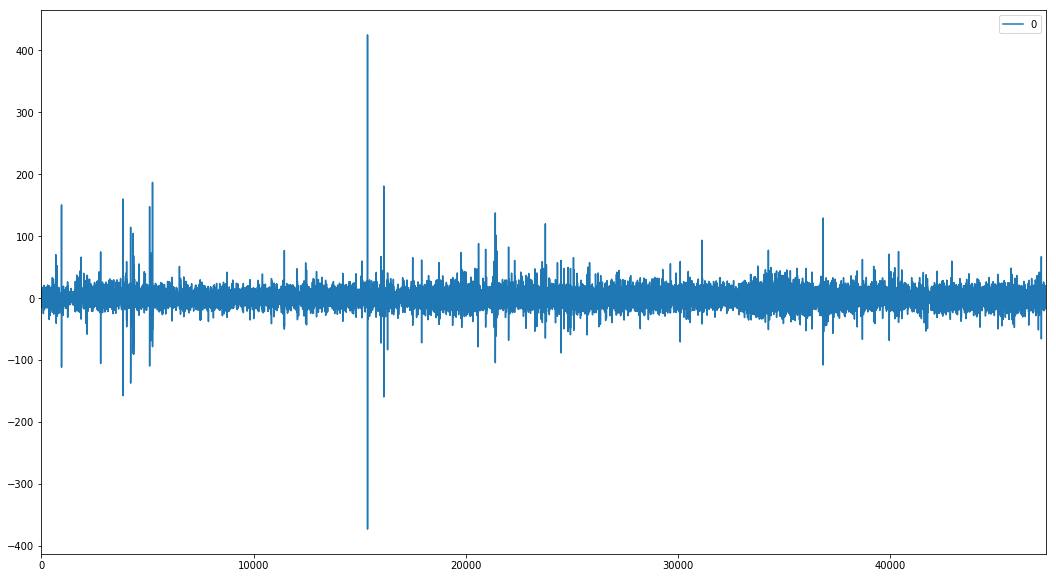

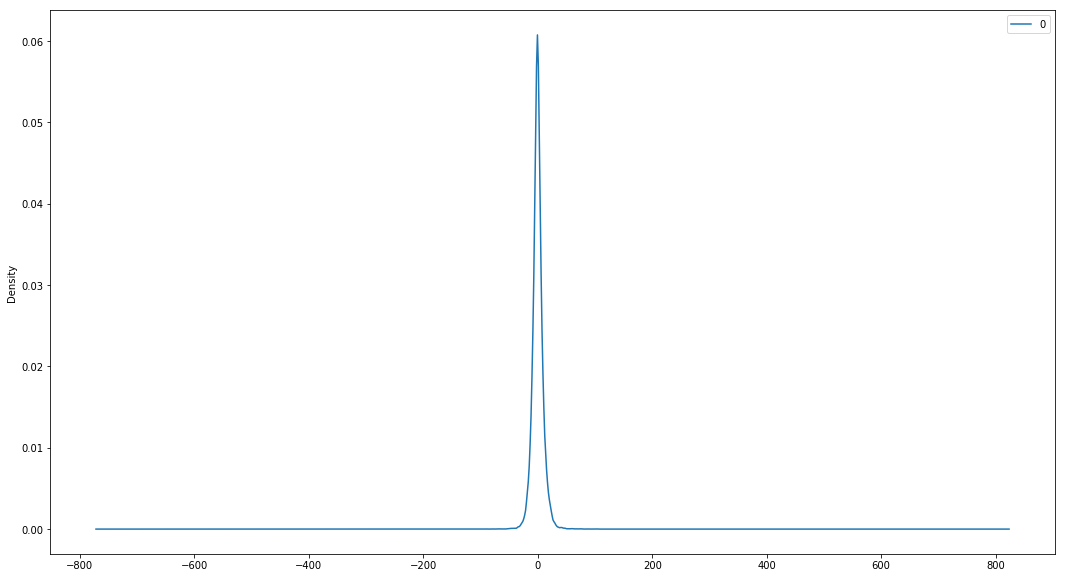

                  0
count  47351.000000
mean      -0.000218
std       10.085857
min     -373.012129
25%       -4.904066
50%       -0.296103
75%        4.476690
max      424.713325


In [24]:
model = ARIMA(df["Mannerheimintie"], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(18,10))
pyplot.show()
residuals.plot(kind='kde', figsize=(18,10))
pyplot.show()
print(residuals.describe())

predicted=36.086368, expected=36.000000
predicted=37.332654, expected=29.000000
predicted=30.940901, expected=22.000000
predicted=24.515883, expected=25.000000
predicted=26.683784, expected=30.000000
predicted=29.540808, expected=42.000000
predicted=39.124822, expected=44.000000
predicted=41.031286, expected=37.000000
predicted=36.338667, expected=42.000000
predicted=40.853281, expected=28.000000
predicted=30.013583, expected=29.000000
predicted=31.203311, expected=32.000000
predicted=32.645870, expected=49.000000
predicted=45.525100, expected=35.000000
predicted=35.234872, expected=38.000000
predicted=37.841850, expected=40.000000
predicted=39.091493, expected=36.000000
predicted=36.309188, expected=20.000000
predicted=24.409479, expected=24.000000
predicted=26.156895, expected=20.000000
predicted=21.984664, expected=19.000000
predicted=20.899403, expected=26.000000
predicted=25.661387, expected=17.000000
predicted=17.826672, expected=36.000000
predicted=33.155396, expected=35.000000


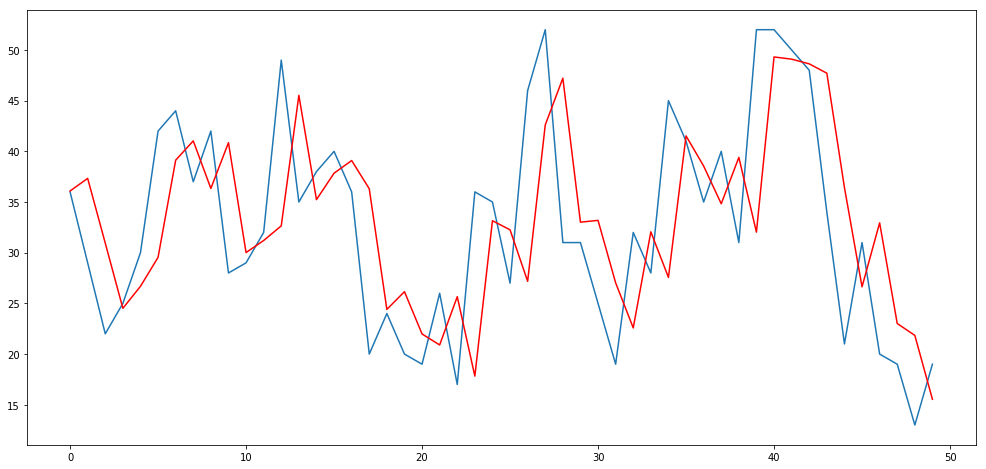

In [33]:
data = df["Mannerheimintie"].values
size = int(len(data) - 50)
train, test = data[0:size], data[size:len(data)]
history = train.tolist()
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.figure(figsize=(17,8))
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Deep learning model: LSTM